In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os import path

import multiprocessing as MP
import sys
from collections import defaultdict
from scipy.stats import spearmanr, kendalltau, mannwhitneyu
import datetime
import matplotlib as mpl
import dill

In [4]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 3,
                                           'lines.markersize': 10,
                                           'legend.fontsize': 24})
sns.set_palette("Set1")

# Data location

Functions and constants to run the experiments are defined here.

In [5]:
%run -i spaced_rep_code.py
%run -i plot_utils.py

Data files should be kept at these paths.

In [8]:
raw_data = "./data/duolingo_reduced.csv"
dict_data = "./data/duo_dict.dill"

model_weights_file = "power.duolingo.weights"

# Load Data

In [9]:
%%time
df_duo = pd.read_csv(raw_data)

CPU times: user 15.9 s, sys: 1.65 s, total: 17.5 s
Wall time: 17.5 s


In [10]:
df_duo['lexeme_comp'] = df_duo['learning_language']+":"+df_duo['lexeme_string']
convert = df_duo[['lexeme_comp','lexeme_id']].set_index('lexeme_comp').to_dict()['lexeme_id']

In [11]:
%%time
results_duo = pd.read_csv(open(model_weights_file, 'rb'),
                          sep="\t",
                          names=['label','value'],
                          header=None)

results_duo = results_duo.set_index("label")

B = results_duo.loc["B"]
start = 5

duo_lexeme_difficulty = 2**(-(results_duo[start:]+results_duo.loc['bias']))
new_index = []
for ind in duo_lexeme_difficulty.index:
    new_index.append(convert[ind])
    
duo_lexeme_difficulty['new_index'] = new_index
duo_lexeme_difficulty.set_index('new_index',inplace=True)

duo_map_lexeme = dict([(l_id,ind) for ind, l_id in enumerate(duo_lexeme_difficulty.index)])

duo_lexeme_difficulty = duo_lexeme_difficulty['value'].tolist()
duo_alpha = (-2**(-results_duo.loc['right'])+1).iloc[0]
duo_beta = (2**(-results_duo.loc['wrong'])-1).iloc[0]

CPU times: user 226 ms, sys: 3.11 ms, total: 229 ms
Wall time: 228 ms


In [12]:
%%time
duo_dict = dill.load(open(dict_data, 'rb'))

CPU times: user 53.5 s, sys: 8.15 s, total: 1min 1s
Wall time: 1min 1s


In [55]:
len(duo_dict)

107867

In [13]:
%%time
duo_pairs = get_unique_user_lexeme(duo_dict)

CPU times: user 19.5 s, sys: 182 ms, total: 19.7 s
Wall time: 19.7 s


In [14]:
%%time
initial_cond = df_duo[["lexeme_id","user_id","timestamp"]].groupby(["lexeme_id","user_id"]).min()["timestamp"]
initial_cond = initial_cond.to_dict()
df_duo_index_set = df_duo.copy().set_index(["lexeme_id","user_id","timestamp"])
df_duo_index_set.sort_index(inplace=True)

CPU times: user 1min 10s, sys: 4.52 s, total: 1min 15s
Wall time: 1min 14s


In [15]:
%%time
total_correct = []
total_seen = []
for ind, (u_id,l_id) in enumerate(duo_pairs):
    for item in duo_dict[u_id][l_id]:
        time = initial_cond[(l_id,u_id)]
        correct = df_duo_index_set["history_correct"].loc[(l_id,u_id,time)].tolist()[0]
        seen = df_duo_index_set["history_seen"].loc[(l_id,u_id,time)].tolist()[0]
        total_correct.append(correct)
        total_seen.append(seen)

CPU times: user 4h 17min 59s, sys: 57.8 s, total: 4h 18min 57s
Wall time: 4h 18min 11s


In [16]:
%%time
right = results_duo.loc['right'][0]
wrong = results_duo.loc['wrong'][0]
temp_duo_map_lexeme = {}
for ind, (u_id,l_id) in enumerate(duo_pairs):
    if ind % 1000 == 0:
        print(datetime.datetime.now().isoformat(), ind, '/', len(duo_pairs))
    for item in duo_dict[u_id][l_id]:
        time = initial_cond[(l_id,u_id)]
        correct = df_duo_index_set["history_correct"].loc[(l_id,u_id,time)].tolist()[0]
        seen = df_duo_index_set["history_seen"].loc[(l_id,u_id,time)].tolist()[0]
        #print(correct, seen)
        temp = None
        if l_id not in temp_duo_map_lexeme:
            temp_duo_map_lexeme[l_id] = duo_lexeme_difficulty[duo_map_lexeme[l_id]]
        temp = temp_duo_map_lexeme[l_id]
        item['n_0'] =temp*\
                        2**(-(right*correct+\
                              wrong*(seen-correct)))

2019-01-10T23:22:00.165905 0 / 5291058
2019-01-10T23:22:03.177796 1000 / 5291058
2019-01-10T23:22:06.336454 2000 / 5291058
2019-01-10T23:22:09.189549 3000 / 5291058
2019-01-10T23:22:14.888879 4000 / 5291058
2019-01-10T23:22:19.010982 5000 / 5291058
2019-01-10T23:22:22.378171 6000 / 5291058
2019-01-10T23:22:24.785269 7000 / 5291058
2019-01-10T23:22:27.094681 8000 / 5291058
2019-01-10T23:22:30.066902 9000 / 5291058
2019-01-10T23:22:33.543305 10000 / 5291058
2019-01-10T23:22:36.257220 11000 / 5291058
2019-01-10T23:22:38.586176 12000 / 5291058
2019-01-10T23:22:41.279722 13000 / 5291058
2019-01-10T23:22:44.205928 14000 / 5291058
2019-01-10T23:22:47.089321 15000 / 5291058
2019-01-10T23:22:49.719782 16000 / 5291058
2019-01-10T23:22:52.819476 17000 / 5291058
2019-01-10T23:22:56.399040 18000 / 5291058
2019-01-10T23:22:59.493645 19000 / 5291058
2019-01-10T23:23:02.735805 20000 / 5291058
2019-01-10T23:23:05.189658 21000 / 5291058
2019-01-10T23:23:07.903269 22000 / 5291058
2019-01-10T23:23:10.5248

2019-01-10T23:31:28.211419 189000 / 5291058
2019-01-10T23:31:53.545861 190000 / 5291058
2019-01-10T23:31:56.628778 191000 / 5291058
2019-01-10T23:31:59.459065 192000 / 5291058
2019-01-10T23:32:01.845678 193000 / 5291058
2019-01-10T23:32:04.680849 194000 / 5291058
2019-01-10T23:32:06.881373 195000 / 5291058
2019-01-10T23:32:09.469391 196000 / 5291058
2019-01-10T23:32:12.592544 197000 / 5291058
2019-01-10T23:32:15.387680 198000 / 5291058
2019-01-10T23:32:17.908447 199000 / 5291058
2019-01-10T23:32:20.544522 200000 / 5291058
2019-01-10T23:32:23.517650 201000 / 5291058
2019-01-10T23:32:27.055477 202000 / 5291058
2019-01-10T23:32:29.675589 203000 / 5291058
2019-01-10T23:32:32.237973 204000 / 5291058
2019-01-10T23:32:35.958602 205000 / 5291058
2019-01-10T23:32:44.037739 206000 / 5291058
2019-01-10T23:32:46.789620 207000 / 5291058
2019-01-10T23:32:49.511164 208000 / 5291058
2019-01-10T23:32:51.841903 209000 / 5291058
2019-01-10T23:32:54.231129 210000 / 5291058
2019-01-10T23:32:56.887782 21100

2019-01-10T23:41:38.078642 375000 / 5291058
2019-01-10T23:41:41.595544 376000 / 5291058
2019-01-10T23:41:44.856376 377000 / 5291058
2019-01-10T23:41:47.310601 378000 / 5291058
2019-01-10T23:41:50.109156 379000 / 5291058
2019-01-10T23:41:52.926327 380000 / 5291058
2019-01-10T23:41:56.067504 381000 / 5291058
2019-01-10T23:41:59.951196 382000 / 5291058
2019-01-10T23:42:03.795311 383000 / 5291058
2019-01-10T23:42:06.844817 384000 / 5291058
2019-01-10T23:42:09.361919 385000 / 5291058
2019-01-10T23:42:12.059911 386000 / 5291058
2019-01-10T23:42:14.264990 387000 / 5291058
2019-01-10T23:42:16.771266 388000 / 5291058
2019-01-10T23:42:20.491508 389000 / 5291058
2019-01-10T23:42:23.449620 390000 / 5291058
2019-01-10T23:42:26.821234 391000 / 5291058
2019-01-10T23:42:29.867197 392000 / 5291058
2019-01-10T23:42:33.300627 393000 / 5291058
2019-01-10T23:42:36.032661 394000 / 5291058
2019-01-10T23:42:39.168577 395000 / 5291058
2019-01-10T23:42:42.308159 396000 / 5291058
2019-01-10T23:42:44.615810 39700

2019-01-10T23:51:35.679407 561000 / 5291058
2019-01-10T23:51:38.936649 562000 / 5291058
2019-01-10T23:51:42.730519 563000 / 5291058
2019-01-10T23:51:45.941993 564000 / 5291058
2019-01-10T23:51:49.552920 565000 / 5291058
2019-01-10T23:51:54.261222 566000 / 5291058
2019-01-10T23:51:58.818546 567000 / 5291058
2019-01-10T23:52:01.509735 568000 / 5291058
2019-01-10T23:52:03.907537 569000 / 5291058
2019-01-10T23:52:07.238686 570000 / 5291058
2019-01-10T23:52:09.643275 571000 / 5291058
2019-01-10T23:52:12.391030 572000 / 5291058
2019-01-10T23:52:15.146948 573000 / 5291058
2019-01-10T23:52:17.969969 574000 / 5291058
2019-01-10T23:52:21.165402 575000 / 5291058
2019-01-10T23:52:23.373399 576000 / 5291058
2019-01-10T23:52:25.844227 577000 / 5291058
2019-01-10T23:52:28.768364 578000 / 5291058
2019-01-10T23:52:31.502480 579000 / 5291058
2019-01-10T23:52:34.277197 580000 / 5291058
2019-01-10T23:52:37.835590 581000 / 5291058
2019-01-10T23:52:40.928076 582000 / 5291058
2019-01-10T23:52:43.564676 58300

2019-01-11T00:01:27.638678 747000 / 5291058
2019-01-11T00:01:30.172349 748000 / 5291058
2019-01-11T00:01:34.470924 749000 / 5291058
2019-01-11T00:01:37.701103 750000 / 5291058
2019-01-11T00:01:40.663654 751000 / 5291058
2019-01-11T00:01:43.732009 752000 / 5291058
2019-01-11T00:01:47.561744 753000 / 5291058
2019-01-11T00:01:50.555375 754000 / 5291058
2019-01-11T00:01:53.937907 755000 / 5291058
2019-01-11T00:01:57.773126 756000 / 5291058
2019-01-11T00:02:00.298058 757000 / 5291058
2019-01-11T00:02:03.683354 758000 / 5291058
2019-01-11T00:02:05.935778 759000 / 5291058
2019-01-11T00:02:08.806803 760000 / 5291058
2019-01-11T00:02:12.721969 761000 / 5291058
2019-01-11T00:02:17.145346 762000 / 5291058
2019-01-11T00:02:20.241319 763000 / 5291058
2019-01-11T00:02:23.836137 764000 / 5291058
2019-01-11T00:02:26.398995 765000 / 5291058
2019-01-11T00:02:29.381640 766000 / 5291058
2019-01-11T00:02:32.063943 767000 / 5291058
2019-01-11T00:02:34.644443 768000 / 5291058
2019-01-11T00:02:37.845381 76900

2019-01-11T00:11:28.765759 933000 / 5291058
2019-01-11T00:11:31.044533 934000 / 5291058
2019-01-11T00:11:33.883173 935000 / 5291058
2019-01-11T00:11:36.298853 936000 / 5291058
2019-01-11T00:11:41.266403 937000 / 5291058
2019-01-11T00:11:44.294125 938000 / 5291058
2019-01-11T00:11:48.062623 939000 / 5291058
2019-01-11T00:11:50.442656 940000 / 5291058
2019-01-11T00:11:53.518510 941000 / 5291058
2019-01-11T00:11:56.769086 942000 / 5291058
2019-01-11T00:12:00.558767 943000 / 5291058
2019-01-11T00:12:03.907770 944000 / 5291058
2019-01-11T00:12:08.464940 945000 / 5291058
2019-01-11T00:12:13.446947 946000 / 5291058
2019-01-11T00:12:18.173048 947000 / 5291058
2019-01-11T00:12:21.226161 948000 / 5291058
2019-01-11T00:12:24.540788 949000 / 5291058
2019-01-11T00:12:27.106389 950000 / 5291058
2019-01-11T00:12:30.937904 951000 / 5291058
2019-01-11T00:12:36.312475 952000 / 5291058
2019-01-11T00:12:40.081755 953000 / 5291058
2019-01-11T00:12:43.655885 954000 / 5291058
2019-01-11T00:12:46.662738 95500

2019-01-11T00:21:29.538553 1116000 / 5291058
2019-01-11T00:21:35.835160 1117000 / 5291058
2019-01-11T00:21:38.325994 1118000 / 5291058
2019-01-11T00:21:41.247336 1119000 / 5291058
2019-01-11T00:21:45.848162 1120000 / 5291058
2019-01-11T00:21:49.996794 1121000 / 5291058
2019-01-11T00:21:54.089479 1122000 / 5291058
2019-01-11T00:21:57.436469 1123000 / 5291058
2019-01-11T00:22:00.371663 1124000 / 5291058
2019-01-11T00:22:03.575841 1125000 / 5291058
2019-01-11T00:22:06.841879 1126000 / 5291058
2019-01-11T00:22:09.458244 1127000 / 5291058
2019-01-11T00:22:12.495059 1128000 / 5291058
2019-01-11T00:22:15.537314 1129000 / 5291058
2019-01-11T00:22:18.839113 1130000 / 5291058
2019-01-11T00:22:23.915868 1131000 / 5291058
2019-01-11T00:22:26.839179 1132000 / 5291058
2019-01-11T00:22:30.282436 1133000 / 5291058
2019-01-11T00:22:33.893495 1134000 / 5291058
2019-01-11T00:22:37.040868 1135000 / 5291058
2019-01-11T00:22:41.026885 1136000 / 5291058
2019-01-11T00:22:44.667362 1137000 / 5291058
2019-01-11

2019-01-11T00:31:47.433868 1298000 / 5291058
2019-01-11T00:31:53.012722 1299000 / 5291058
2019-01-11T00:31:55.765436 1300000 / 5291058
2019-01-11T00:31:59.933236 1301000 / 5291058
2019-01-11T00:32:03.179368 1302000 / 5291058
2019-01-11T00:32:06.666585 1303000 / 5291058
2019-01-11T00:32:09.514108 1304000 / 5291058
2019-01-11T00:32:13.391138 1305000 / 5291058
2019-01-11T00:32:20.096631 1306000 / 5291058
2019-01-11T00:32:23.942410 1307000 / 5291058
2019-01-11T00:32:27.027386 1308000 / 5291058
2019-01-11T00:32:30.371045 1309000 / 5291058
2019-01-11T00:32:34.307559 1310000 / 5291058
2019-01-11T00:32:37.477919 1311000 / 5291058
2019-01-11T00:32:40.839247 1312000 / 5291058
2019-01-11T00:32:44.211438 1313000 / 5291058
2019-01-11T00:32:47.981171 1314000 / 5291058
2019-01-11T00:32:52.060774 1315000 / 5291058
2019-01-11T00:32:55.561170 1316000 / 5291058
2019-01-11T00:32:58.206560 1317000 / 5291058
2019-01-11T00:33:01.147060 1318000 / 5291058
2019-01-11T00:33:05.057453 1319000 / 5291058
2019-01-11

2019-01-11T00:41:57.667570 1480000 / 5291058
2019-01-11T00:42:01.104406 1481000 / 5291058
2019-01-11T00:42:04.178204 1482000 / 5291058
2019-01-11T00:42:06.755425 1483000 / 5291058
2019-01-11T00:42:10.327829 1484000 / 5291058
2019-01-11T00:42:12.997587 1485000 / 5291058
2019-01-11T00:42:16.208253 1486000 / 5291058
2019-01-11T00:42:19.743808 1487000 / 5291058
2019-01-11T00:42:23.284090 1488000 / 5291058
2019-01-11T00:42:26.049411 1489000 / 5291058
2019-01-11T00:42:28.590203 1490000 / 5291058
2019-01-11T00:42:31.139143 1491000 / 5291058
2019-01-11T00:42:34.199926 1492000 / 5291058
2019-01-11T00:42:37.346836 1493000 / 5291058
2019-01-11T00:42:40.399143 1494000 / 5291058
2019-01-11T00:42:42.701406 1495000 / 5291058
2019-01-11T00:42:45.683194 1496000 / 5291058
2019-01-11T00:42:49.107522 1497000 / 5291058
2019-01-11T00:42:51.749495 1498000 / 5291058
2019-01-11T00:42:54.695281 1499000 / 5291058
2019-01-11T00:42:58.509519 1500000 / 5291058
2019-01-11T00:43:02.082319 1501000 / 5291058
2019-01-11

2019-01-11T00:52:13.719936 1663000 / 5291058
2019-01-11T00:52:16.528230 1664000 / 5291058
2019-01-11T00:52:19.027116 1665000 / 5291058
2019-01-11T00:52:23.311449 1666000 / 5291058
2019-01-11T00:52:28.675204 1667000 / 5291058
2019-01-11T00:52:31.456614 1668000 / 5291058
2019-01-11T00:52:41.297268 1669000 / 5291058
2019-01-11T00:52:45.568410 1670000 / 5291058
2019-01-11T00:52:48.969779 1671000 / 5291058
2019-01-11T00:52:52.172559 1672000 / 5291058
2019-01-11T00:52:55.013643 1673000 / 5291058
2019-01-11T00:52:57.999975 1674000 / 5291058
2019-01-11T00:53:00.752792 1675000 / 5291058
2019-01-11T00:53:04.177759 1676000 / 5291058
2019-01-11T00:53:07.619318 1677000 / 5291058
2019-01-11T00:53:10.917340 1678000 / 5291058
2019-01-11T00:53:13.508369 1679000 / 5291058
2019-01-11T00:53:16.586199 1680000 / 5291058
2019-01-11T00:53:19.306918 1681000 / 5291058
2019-01-11T00:53:21.980357 1682000 / 5291058
2019-01-11T00:53:24.691038 1683000 / 5291058
2019-01-11T00:53:27.519522 1684000 / 5291058
2019-01-11

2019-01-11T01:02:25.199231 1846000 / 5291058
2019-01-11T01:02:29.625428 1847000 / 5291058
2019-01-11T01:02:37.531206 1848000 / 5291058
2019-01-11T01:02:40.084590 1849000 / 5291058
2019-01-11T01:02:43.658394 1850000 / 5291058
2019-01-11T01:02:48.667131 1851000 / 5291058
2019-01-11T01:02:53.047179 1852000 / 5291058
2019-01-11T01:02:56.212562 1853000 / 5291058
2019-01-11T01:02:58.514955 1854000 / 5291058
2019-01-11T01:03:01.757321 1855000 / 5291058
2019-01-11T01:03:05.376333 1856000 / 5291058
2019-01-11T01:03:08.429999 1857000 / 5291058
2019-01-11T01:03:11.193725 1858000 / 5291058
2019-01-11T01:03:13.661933 1859000 / 5291058
2019-01-11T01:03:17.678264 1860000 / 5291058
2019-01-11T01:03:20.266741 1861000 / 5291058
2019-01-11T01:03:23.648902 1862000 / 5291058
2019-01-11T01:03:26.577903 1863000 / 5291058
2019-01-11T01:03:29.500912 1864000 / 5291058
2019-01-11T01:03:32.533760 1865000 / 5291058
2019-01-11T01:03:35.310218 1866000 / 5291058
2019-01-11T01:03:39.289566 1867000 / 5291058
2019-01-11

2019-01-11T01:12:55.417689 2029000 / 5291058
2019-01-11T01:12:59.464564 2030000 / 5291058
2019-01-11T01:13:02.307260 2031000 / 5291058
2019-01-11T01:13:05.371497 2032000 / 5291058
2019-01-11T01:13:11.209524 2033000 / 5291058
2019-01-11T01:13:14.324104 2034000 / 5291058
2019-01-11T01:13:19.434929 2035000 / 5291058
2019-01-11T01:13:23.212928 2036000 / 5291058
2019-01-11T01:13:25.947969 2037000 / 5291058
2019-01-11T01:13:29.180566 2038000 / 5291058
2019-01-11T01:13:32.028561 2039000 / 5291058
2019-01-11T01:13:35.222662 2040000 / 5291058
2019-01-11T01:13:37.558083 2041000 / 5291058
2019-01-11T01:13:43.314485 2042000 / 5291058
2019-01-11T01:13:45.836296 2043000 / 5291058
2019-01-11T01:13:48.356593 2044000 / 5291058
2019-01-11T01:13:52.828173 2045000 / 5291058
2019-01-11T01:13:55.089751 2046000 / 5291058
2019-01-11T01:13:58.258681 2047000 / 5291058
2019-01-11T01:14:01.424067 2048000 / 5291058
2019-01-11T01:14:04.938829 2049000 / 5291058
2019-01-11T01:14:08.118710 2050000 / 5291058
2019-01-11

2019-01-11T01:23:11.250177 2212000 / 5291058
2019-01-11T01:23:15.601317 2213000 / 5291058
2019-01-11T01:23:18.609626 2214000 / 5291058
2019-01-11T01:23:20.940080 2215000 / 5291058
2019-01-11T01:23:24.294307 2216000 / 5291058
2019-01-11T01:23:27.144236 2217000 / 5291058
2019-01-11T01:23:30.211525 2218000 / 5291058
2019-01-11T01:23:32.766831 2219000 / 5291058
2019-01-11T01:23:35.308681 2220000 / 5291058
2019-01-11T01:23:37.806907 2221000 / 5291058
2019-01-11T01:23:40.028712 2222000 / 5291058
2019-01-11T01:23:41.789855 2223000 / 5291058
2019-01-11T01:23:44.550955 2224000 / 5291058
2019-01-11T01:23:47.124208 2225000 / 5291058
2019-01-11T01:23:49.871404 2226000 / 5291058
2019-01-11T01:23:53.238693 2227000 / 5291058
2019-01-11T01:23:57.521983 2228000 / 5291058
2019-01-11T01:23:59.683811 2229000 / 5291058
2019-01-11T01:24:02.742474 2230000 / 5291058
2019-01-11T01:24:05.500873 2231000 / 5291058
2019-01-11T01:24:08.211510 2232000 / 5291058
2019-01-11T01:24:11.187545 2233000 / 5291058
2019-01-11

2019-01-11T01:32:36.361085 2395000 / 5291058
2019-01-11T01:32:38.571673 2396000 / 5291058
2019-01-11T01:32:43.458657 2397000 / 5291058
2019-01-11T01:32:46.575652 2398000 / 5291058
2019-01-11T01:32:50.009484 2399000 / 5291058
2019-01-11T01:32:54.357587 2400000 / 5291058
2019-01-11T01:32:58.390321 2401000 / 5291058
2019-01-11T01:33:01.336802 2402000 / 5291058
2019-01-11T01:33:02.838703 2403000 / 5291058
2019-01-11T01:33:05.572093 2404000 / 5291058
2019-01-11T01:33:08.345256 2405000 / 5291058
2019-01-11T01:33:12.560161 2406000 / 5291058
2019-01-11T01:33:16.403348 2407000 / 5291058
2019-01-11T01:33:19.487631 2408000 / 5291058
2019-01-11T01:33:22.497361 2409000 / 5291058
2019-01-11T01:33:24.794184 2410000 / 5291058
2019-01-11T01:33:26.882671 2411000 / 5291058
2019-01-11T01:33:29.615847 2412000 / 5291058
2019-01-11T01:33:32.356077 2413000 / 5291058
2019-01-11T01:33:35.269581 2414000 / 5291058
2019-01-11T01:33:38.610352 2415000 / 5291058
2019-01-11T01:33:41.756690 2416000 / 5291058
2019-01-11

2019-01-11T01:41:59.734845 2577000 / 5291058
2019-01-11T01:42:02.302185 2578000 / 5291058
2019-01-11T01:42:05.599159 2579000 / 5291058
2019-01-11T01:42:08.745649 2580000 / 5291058
2019-01-11T01:42:11.801023 2581000 / 5291058
2019-01-11T01:42:15.379526 2582000 / 5291058
2019-01-11T01:42:17.734947 2583000 / 5291058
2019-01-11T01:42:19.880993 2584000 / 5291058
2019-01-11T01:42:22.361390 2585000 / 5291058
2019-01-11T01:42:25.863083 2586000 / 5291058
2019-01-11T01:42:32.157093 2587000 / 5291058
2019-01-11T01:42:34.892920 2588000 / 5291058
2019-01-11T01:42:37.382376 2589000 / 5291058
2019-01-11T01:42:42.416287 2590000 / 5291058
2019-01-11T01:42:45.438658 2591000 / 5291058
2019-01-11T01:42:48.219728 2592000 / 5291058
2019-01-11T01:42:50.830318 2593000 / 5291058
2019-01-11T01:42:53.542282 2594000 / 5291058
2019-01-11T01:42:55.583795 2595000 / 5291058
2019-01-11T01:42:58.862467 2596000 / 5291058
2019-01-11T01:43:02.004200 2597000 / 5291058
2019-01-11T01:43:05.420471 2598000 / 5291058
2019-01-11

2019-01-11T01:51:54.902671 2759000 / 5291058
2019-01-11T01:51:59.511235 2760000 / 5291058
2019-01-11T01:52:03.346566 2761000 / 5291058
2019-01-11T01:52:05.621627 2762000 / 5291058
2019-01-11T01:52:09.200806 2763000 / 5291058
2019-01-11T01:52:13.340814 2764000 / 5291058
2019-01-11T01:52:15.896949 2765000 / 5291058
2019-01-11T01:52:20.307903 2766000 / 5291058
2019-01-11T01:52:23.279609 2767000 / 5291058
2019-01-11T01:52:26.878576 2768000 / 5291058
2019-01-11T01:52:30.549969 2769000 / 5291058
2019-01-11T01:52:34.143364 2770000 / 5291058
2019-01-11T01:52:36.793201 2771000 / 5291058
2019-01-11T01:52:40.809819 2772000 / 5291058
2019-01-11T01:52:44.404221 2773000 / 5291058
2019-01-11T01:52:47.345149 2774000 / 5291058
2019-01-11T01:52:51.275788 2775000 / 5291058
2019-01-11T01:52:56.047750 2776000 / 5291058
2019-01-11T01:52:59.858757 2777000 / 5291058
2019-01-11T01:53:03.185666 2778000 / 5291058
2019-01-11T01:53:06.350673 2779000 / 5291058
2019-01-11T01:53:09.584146 2780000 / 5291058
2019-01-11

2019-01-11T02:02:18.179572 2942000 / 5291058
2019-01-11T02:02:24.708173 2943000 / 5291058
2019-01-11T02:02:27.924942 2944000 / 5291058
2019-01-11T02:02:30.616629 2945000 / 5291058
2019-01-11T02:02:34.527629 2946000 / 5291058
2019-01-11T02:02:37.285789 2947000 / 5291058
2019-01-11T02:02:39.952721 2948000 / 5291058
2019-01-11T02:02:43.838633 2949000 / 5291058
2019-01-11T02:02:47.209506 2950000 / 5291058
2019-01-11T02:02:53.088578 2951000 / 5291058
2019-01-11T02:02:56.612861 2952000 / 5291058
2019-01-11T02:02:59.920124 2953000 / 5291058
2019-01-11T02:03:02.636439 2954000 / 5291058
2019-01-11T02:03:05.429761 2955000 / 5291058
2019-01-11T02:03:08.668864 2956000 / 5291058
2019-01-11T02:03:11.571398 2957000 / 5291058
2019-01-11T02:03:15.130114 2958000 / 5291058
2019-01-11T02:03:18.768121 2959000 / 5291058
2019-01-11T02:03:21.642028 2960000 / 5291058
2019-01-11T02:03:24.517503 2961000 / 5291058
2019-01-11T02:03:27.865406 2962000 / 5291058
2019-01-11T02:03:30.330378 2963000 / 5291058
2019-01-11

2019-01-11T02:11:29.429039 3124000 / 5291058
2019-01-11T02:11:31.864141 3125000 / 5291058
2019-01-11T02:11:34.820993 3126000 / 5291058
2019-01-11T02:11:37.641387 3127000 / 5291058
2019-01-11T02:11:40.038082 3128000 / 5291058
2019-01-11T02:11:42.549258 3129000 / 5291058
2019-01-11T02:11:45.129207 3130000 / 5291058
2019-01-11T02:11:47.586693 3131000 / 5291058
2019-01-11T02:11:50.420846 3132000 / 5291058
2019-01-11T02:11:52.625278 3133000 / 5291058
2019-01-11T02:11:54.190674 3134000 / 5291058
2019-01-11T02:11:58.331343 3135000 / 5291058
2019-01-11T02:12:00.767847 3136000 / 5291058
2019-01-11T02:12:03.238933 3137000 / 5291058
2019-01-11T02:12:06.481022 3138000 / 5291058
2019-01-11T02:12:09.141177 3139000 / 5291058
2019-01-11T02:12:12.102410 3140000 / 5291058
2019-01-11T02:12:15.257250 3141000 / 5291058
2019-01-11T02:12:18.478111 3142000 / 5291058
2019-01-11T02:12:22.975724 3143000 / 5291058
2019-01-11T02:12:25.889262 3144000 / 5291058
2019-01-11T02:12:28.298072 3145000 / 5291058
2019-01-11

2019-01-11T02:19:24.234066 3307000 / 5291058
2019-01-11T02:19:26.464547 3308000 / 5291058
2019-01-11T02:19:28.615573 3309000 / 5291058
2019-01-11T02:19:31.328939 3310000 / 5291058
2019-01-11T02:19:33.881362 3311000 / 5291058
2019-01-11T02:19:36.572891 3312000 / 5291058
2019-01-11T02:19:38.693634 3313000 / 5291058
2019-01-11T02:19:40.884312 3314000 / 5291058
2019-01-11T02:19:43.334560 3315000 / 5291058
2019-01-11T02:19:45.585751 3316000 / 5291058
2019-01-11T02:19:47.922798 3317000 / 5291058
2019-01-11T02:19:50.086495 3318000 / 5291058
2019-01-11T02:19:52.568073 3319000 / 5291058
2019-01-11T02:19:55.464833 3320000 / 5291058
2019-01-11T02:19:58.158822 3321000 / 5291058
2019-01-11T02:20:00.813661 3322000 / 5291058
2019-01-11T02:20:03.424751 3323000 / 5291058
2019-01-11T02:20:05.830049 3324000 / 5291058
2019-01-11T02:20:08.915994 3325000 / 5291058
2019-01-11T02:20:12.013302 3326000 / 5291058
2019-01-11T02:20:14.502050 3327000 / 5291058
2019-01-11T02:20:17.177243 3328000 / 5291058
2019-01-11

2019-01-11T02:26:57.342549 3489000 / 5291058
2019-01-11T02:26:59.355653 3490000 / 5291058
2019-01-11T02:27:01.435035 3491000 / 5291058
2019-01-11T02:27:04.602717 3492000 / 5291058
2019-01-11T02:27:06.789211 3493000 / 5291058
2019-01-11T02:27:09.307988 3494000 / 5291058
2019-01-11T02:27:12.033377 3495000 / 5291058
2019-01-11T02:27:14.436607 3496000 / 5291058
2019-01-11T02:27:17.525070 3497000 / 5291058
2019-01-11T02:27:21.221933 3498000 / 5291058
2019-01-11T02:27:23.385765 3499000 / 5291058
2019-01-11T02:27:25.611875 3500000 / 5291058
2019-01-11T02:27:27.720794 3501000 / 5291058
2019-01-11T02:27:31.564194 3502000 / 5291058
2019-01-11T02:27:33.834941 3503000 / 5291058
2019-01-11T02:27:37.227505 3504000 / 5291058
2019-01-11T02:27:39.008590 3505000 / 5291058
2019-01-11T02:27:41.523443 3506000 / 5291058
2019-01-11T02:27:43.459615 3507000 / 5291058
2019-01-11T02:27:45.822291 3508000 / 5291058
2019-01-11T02:27:47.760252 3509000 / 5291058
2019-01-11T02:27:50.395472 3510000 / 5291058
2019-01-11

2019-01-11T02:34:43.172304 3671000 / 5291058
2019-01-11T02:34:47.445777 3672000 / 5291058
2019-01-11T02:34:49.540653 3673000 / 5291058
2019-01-11T02:34:52.102337 3674000 / 5291058
2019-01-11T02:34:54.499154 3675000 / 5291058
2019-01-11T02:34:57.131159 3676000 / 5291058
2019-01-11T02:34:59.267121 3677000 / 5291058
2019-01-11T02:35:01.598111 3678000 / 5291058
2019-01-11T02:35:04.400415 3679000 / 5291058
2019-01-11T02:35:06.368300 3680000 / 5291058
2019-01-11T02:35:08.756010 3681000 / 5291058
2019-01-11T02:35:11.074732 3682000 / 5291058
2019-01-11T02:35:13.218835 3683000 / 5291058
2019-01-11T02:35:15.150588 3684000 / 5291058
2019-01-11T02:35:17.062287 3685000 / 5291058
2019-01-11T02:35:19.136726 3686000 / 5291058
2019-01-11T02:35:22.145981 3687000 / 5291058
2019-01-11T02:35:24.274744 3688000 / 5291058
2019-01-11T02:35:26.742966 3689000 / 5291058
2019-01-11T02:35:28.891866 3690000 / 5291058
2019-01-11T02:35:32.693156 3691000 / 5291058
2019-01-11T02:35:34.351600 3692000 / 5291058
2019-01-11

2019-01-11T02:42:30.476333 3854000 / 5291058
2019-01-11T02:42:33.733387 3855000 / 5291058
2019-01-11T02:42:35.852718 3856000 / 5291058
2019-01-11T02:42:38.416997 3857000 / 5291058
2019-01-11T02:42:40.431198 3858000 / 5291058
2019-01-11T02:42:43.470921 3859000 / 5291058
2019-01-11T02:42:45.373562 3860000 / 5291058
2019-01-11T02:42:47.448180 3861000 / 5291058
2019-01-11T02:42:50.374877 3862000 / 5291058
2019-01-11T02:42:53.467714 3863000 / 5291058
2019-01-11T02:42:57.224352 3864000 / 5291058
2019-01-11T02:42:59.829309 3865000 / 5291058
2019-01-11T02:43:01.751918 3866000 / 5291058
2019-01-11T02:43:03.798566 3867000 / 5291058
2019-01-11T02:43:05.814930 3868000 / 5291058
2019-01-11T02:43:09.758936 3869000 / 5291058
2019-01-11T02:43:12.620986 3870000 / 5291058
2019-01-11T02:43:15.843780 3871000 / 5291058
2019-01-11T02:43:18.041524 3872000 / 5291058
2019-01-11T02:43:20.085990 3873000 / 5291058
2019-01-11T02:43:22.213151 3874000 / 5291058
2019-01-11T02:43:24.018461 3875000 / 5291058
2019-01-11

2019-01-11T02:50:36.690188 4037000 / 5291058
2019-01-11T02:50:42.400969 4038000 / 5291058
2019-01-11T02:50:44.715476 4039000 / 5291058
2019-01-11T02:50:48.578300 4040000 / 5291058
2019-01-11T02:50:50.861272 4041000 / 5291058
2019-01-11T02:50:54.319804 4042000 / 5291058
2019-01-11T02:50:56.980310 4043000 / 5291058
2019-01-11T02:50:59.980287 4044000 / 5291058
2019-01-11T02:51:02.152612 4045000 / 5291058
2019-01-11T02:51:04.257432 4046000 / 5291058
2019-01-11T02:51:09.263792 4047000 / 5291058
2019-01-11T02:51:11.182603 4048000 / 5291058
2019-01-11T02:51:13.649819 4049000 / 5291058
2019-01-11T02:51:17.913536 4050000 / 5291058
2019-01-11T02:51:20.061335 4051000 / 5291058
2019-01-11T02:51:22.828491 4052000 / 5291058
2019-01-11T02:51:25.399379 4053000 / 5291058
2019-01-11T02:51:27.768186 4054000 / 5291058
2019-01-11T02:51:30.581575 4055000 / 5291058
2019-01-11T02:51:32.623673 4056000 / 5291058
2019-01-11T02:51:35.944920 4057000 / 5291058
2019-01-11T02:51:39.034939 4058000 / 5291058
2019-01-11

2019-01-11T02:58:39.233279 4219000 / 5291058
2019-01-11T02:58:41.940341 4220000 / 5291058
2019-01-11T02:58:44.838098 4221000 / 5291058
2019-01-11T02:58:48.936630 4222000 / 5291058
2019-01-11T02:58:51.291096 4223000 / 5291058
2019-01-11T02:58:53.932414 4224000 / 5291058
2019-01-11T02:58:56.363995 4225000 / 5291058
2019-01-11T02:58:59.136662 4226000 / 5291058
2019-01-11T02:59:02.798493 4227000 / 5291058
2019-01-11T02:59:05.240395 4228000 / 5291058
2019-01-11T02:59:07.353515 4229000 / 5291058
2019-01-11T02:59:09.579847 4230000 / 5291058
2019-01-11T02:59:12.193234 4231000 / 5291058
2019-01-11T02:59:15.707753 4232000 / 5291058
2019-01-11T02:59:18.899565 4233000 / 5291058
2019-01-11T02:59:21.361592 4234000 / 5291058
2019-01-11T02:59:24.359605 4235000 / 5291058
2019-01-11T02:59:26.784771 4236000 / 5291058
2019-01-11T02:59:29.076804 4237000 / 5291058
2019-01-11T02:59:31.641339 4238000 / 5291058
2019-01-11T02:59:33.998067 4239000 / 5291058
2019-01-11T02:59:36.752874 4240000 / 5291058
2019-01-11

2019-01-11T03:06:21.406787 4401000 / 5291058
2019-01-11T03:06:23.522050 4402000 / 5291058
2019-01-11T03:06:25.895837 4403000 / 5291058
2019-01-11T03:06:28.475574 4404000 / 5291058
2019-01-11T03:06:31.361397 4405000 / 5291058
2019-01-11T03:06:33.586928 4406000 / 5291058
2019-01-11T03:06:35.766471 4407000 / 5291058
2019-01-11T03:06:37.802977 4408000 / 5291058
2019-01-11T03:06:40.075102 4409000 / 5291058
2019-01-11T03:06:41.994471 4410000 / 5291058
2019-01-11T03:06:44.313335 4411000 / 5291058
2019-01-11T03:06:46.217838 4412000 / 5291058
2019-01-11T03:06:48.544219 4413000 / 5291058
2019-01-11T03:06:51.174231 4414000 / 5291058
2019-01-11T03:06:54.082986 4415000 / 5291058
2019-01-11T03:06:56.416257 4416000 / 5291058
2019-01-11T03:06:58.680705 4417000 / 5291058
2019-01-11T03:07:02.267909 4418000 / 5291058
2019-01-11T03:07:11.832065 4419000 / 5291058
2019-01-11T03:07:15.375209 4420000 / 5291058
2019-01-11T03:07:18.099814 4421000 / 5291058
2019-01-11T03:07:20.384747 4422000 / 5291058
2019-01-11

2019-01-11T03:15:59.087967 4583000 / 5291058
2019-01-11T03:16:03.061749 4584000 / 5291058
2019-01-11T03:16:05.870262 4585000 / 5291058
2019-01-11T03:16:07.998004 4586000 / 5291058
2019-01-11T03:16:12.670138 4587000 / 5291058
2019-01-11T03:16:16.866389 4588000 / 5291058
2019-01-11T03:16:18.675053 4589000 / 5291058
2019-01-11T03:16:21.278417 4590000 / 5291058
2019-01-11T03:16:24.735180 4591000 / 5291058
2019-01-11T03:16:31.421510 4592000 / 5291058
2019-01-11T03:16:33.898500 4593000 / 5291058
2019-01-11T03:16:37.172404 4594000 / 5291058
2019-01-11T03:16:40.091696 4595000 / 5291058
2019-01-11T03:16:43.988544 4596000 / 5291058
2019-01-11T03:16:49.197417 4597000 / 5291058
2019-01-11T03:16:52.261430 4598000 / 5291058
2019-01-11T03:16:56.405253 4599000 / 5291058
2019-01-11T03:17:00.432286 4600000 / 5291058
2019-01-11T03:17:05.373545 4601000 / 5291058
2019-01-11T03:17:09.113007 4602000 / 5291058
2019-01-11T03:17:12.965666 4603000 / 5291058
2019-01-11T03:17:17.881714 4604000 / 5291058
2019-01-11

2019-01-11T03:26:47.720197 4766000 / 5291058
2019-01-11T03:26:49.554871 4767000 / 5291058
2019-01-11T03:26:51.575959 4768000 / 5291058
2019-01-11T03:26:55.465262 4769000 / 5291058
2019-01-11T03:26:57.803330 4770000 / 5291058
2019-01-11T03:26:59.634102 4771000 / 5291058
2019-01-11T03:27:01.628150 4772000 / 5291058
2019-01-11T03:27:04.923081 4773000 / 5291058
2019-01-11T03:27:07.038547 4774000 / 5291058
2019-01-11T03:27:13.353137 4775000 / 5291058
2019-01-11T03:27:16.390751 4776000 / 5291058
2019-01-11T03:27:19.094811 4777000 / 5291058
2019-01-11T03:27:21.142993 4778000 / 5291058
2019-01-11T03:27:22.808393 4779000 / 5291058
2019-01-11T03:27:24.744779 4780000 / 5291058
2019-01-11T03:27:27.131633 4781000 / 5291058
2019-01-11T03:27:29.718247 4782000 / 5291058
2019-01-11T03:27:31.770544 4783000 / 5291058
2019-01-11T03:27:34.429554 4784000 / 5291058
2019-01-11T03:27:36.307953 4785000 / 5291058
2019-01-11T03:27:38.468519 4786000 / 5291058
2019-01-11T03:27:40.938211 4787000 / 5291058
2019-01-11

2019-01-11T03:34:15.234620 4948000 / 5291058
2019-01-11T03:34:17.520842 4949000 / 5291058
2019-01-11T03:34:21.096869 4950000 / 5291058
2019-01-11T03:34:23.529660 4951000 / 5291058
2019-01-11T03:34:25.832068 4952000 / 5291058
2019-01-11T03:34:27.543866 4953000 / 5291058
2019-01-11T03:34:29.412709 4954000 / 5291058
2019-01-11T03:34:31.825206 4955000 / 5291058
2019-01-11T03:34:34.034567 4956000 / 5291058
2019-01-11T03:34:36.311912 4957000 / 5291058
2019-01-11T03:34:38.331711 4958000 / 5291058
2019-01-11T03:34:40.676719 4959000 / 5291058
2019-01-11T03:34:43.906895 4960000 / 5291058
2019-01-11T03:34:46.299539 4961000 / 5291058
2019-01-11T03:34:49.231936 4962000 / 5291058
2019-01-11T03:34:51.428390 4963000 / 5291058
2019-01-11T03:34:54.484851 4964000 / 5291058
2019-01-11T03:34:56.633947 4965000 / 5291058
2019-01-11T03:34:58.591298 4966000 / 5291058
2019-01-11T03:35:00.922178 4967000 / 5291058
2019-01-11T03:35:03.967764 4968000 / 5291058
2019-01-11T03:35:06.266989 4969000 / 5291058
2019-01-11

2019-01-11T03:41:51.085809 5131000 / 5291058
2019-01-11T03:41:54.177803 5132000 / 5291058
2019-01-11T03:41:56.871420 5133000 / 5291058
2019-01-11T03:41:58.718713 5134000 / 5291058
2019-01-11T03:42:01.668337 5135000 / 5291058
2019-01-11T03:42:05.844716 5136000 / 5291058
2019-01-11T03:42:08.695035 5137000 / 5291058
2019-01-11T03:42:11.371380 5138000 / 5291058
2019-01-11T03:42:13.350699 5139000 / 5291058
2019-01-11T03:42:15.534877 5140000 / 5291058
2019-01-11T03:42:17.359598 5141000 / 5291058
2019-01-11T03:42:19.901246 5142000 / 5291058
2019-01-11T03:42:22.153758 5143000 / 5291058
2019-01-11T03:42:25.152351 5144000 / 5291058
2019-01-11T03:42:28.202476 5145000 / 5291058
2019-01-11T03:42:30.808293 5146000 / 5291058
2019-01-11T03:42:33.941981 5147000 / 5291058
2019-01-11T03:42:36.396351 5148000 / 5291058
2019-01-11T03:42:38.665450 5149000 / 5291058
2019-01-11T03:42:40.862592 5150000 / 5291058
2019-01-11T03:42:42.884050 5151000 / 5291058
2019-01-11T03:42:45.652804 5152000 / 5291058
2019-01-11

In [17]:
%%time
training_pairs = get_training_pairs(duo_dict, duo_pairs)

CPU times: user 2.51 s, sys: 682 ms, total: 3.19 s
Wall time: 3.19 s


In [18]:
print('{:.2f}% of sequences can be used for training/testing.'
      .format(len(training_pairs) / len(duo_pairs) * 100.))

25.28% of sequences can be used for training/testing.


In [19]:
%%time
duo_stats_99 = calc_user_LL_dict(duo_dict, duo_alpha, duo_beta, duo_lexeme_difficulty, duo_map_lexeme, 
                            success_prob=0.99, pairs=duo_pairs, verbose=False)

CPU times: user 2min 3s, sys: 59.3 s, total: 3min 2s
Wall time: 3min 12s


In [20]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('error')
    duo_stats_training = calc_user_LL_dict(
        duo_dict, duo_alpha, duo_beta, duo_lexeme_difficulty, duo_map_lexeme, 
        success_prob=0.99, training=True, pairs=training_pairs, verbose=False,
        n_procs=None
    )

CPU times: user 45.5 s, sys: 35.3 s, total: 1min 20s
Wall time: 1min 25s


In [21]:
%%time
threshold_LL = calc_LL_dict_threshold(duo_dict, alpha=duo_alpha, beta=duo_beta, pairs=duo_pairs, 
                                      lexeme_difficulty=duo_lexeme_difficulty, map_lexeme=duo_map_lexeme,
                                      success_prob=0.99, verbose=False)
merge_with_thres_LL(duo_stats_99, threshold_LL, pairs=duo_pairs)

CPU times: user 2min 32s, sys: 58.1 s, total: 3min 31s
Wall time: 8min 35s


In [22]:
%%time
threshold_LL_training = calc_user_LL_dict_threshold(
    duo_dict, alpha=duo_alpha, beta=duo_beta, pairs=training_pairs, 
    lexeme_difficulty=duo_lexeme_difficulty, map_lexeme=duo_map_lexeme,
    success_prob=0.99, verbose=False, training=True)

merge_with_thres_LL(duo_stats_training, threshold_LL_training, pairs=training_pairs)

CPU times: user 25.4 s, sys: 1min 13s, total: 1min 38s
Wall time: 3min 5s


In [23]:
%%time
duo_durations = get_all_durations(duo_dict, duo_pairs)

CPU times: user 13.8 s, sys: 3.12 s, total: 16.9 s
Wall time: 16.9 s


In [24]:
%%time
# Different sequences be chosen for different T
# The paper contains plots correspondnig to T \in {3, 5, 7}
middle_dur_pairs = filter_by_duration(
    durations_dict=duo_durations, 
    pairs=training_pairs, 
    T=3, alpha=0.1,
    verbose=True)

73317 / 1337453 = 5.48% sequences selected.
CPU times: user 1.42 s, sys: 53.4 ms, total: 1.47 s
Wall time: 1.47 s


# Calculate the metric

In [25]:
%%time
duo_forgetting_rate = calc_empirical_forgetting_rate(duo_dict, pairs=duo_pairs, no_norm=False)
base = calc_empirical_forgetting_rate(duo_dict, pairs=duo_pairs, return_base=True)

CPU times: user 1min 33s, sys: 6.67 s, total: 1min 40s
Wall time: 1min 40s


In [26]:
%%time

perf = duo_forgetting_rate
with_exact_reps = True
quantile = 0.25
with_training = True

def top_k_reps_worker(reps):
    max_reps = None if not with_exact_reps else reps + 1
    stats_dict = duo_stats_99 if not with_training else duo_stats_training
    # pairs = duo_pairs if not with_training else training_pairs
    pairs = duo_pairs if not with_training else middle_dur_pairs
    return reps, calc_top_k_perf(stats_dict, perf, pairs=pairs, quantile=quantile,
                                 min_reps=reps, max_reps=max_reps, with_overall=True,
                                 only_finite=False, with_threshold=True)

reps_range = np.arange(1 if not with_training else 2, 8)

# For performance
with MP.Pool(9) as pool:
    top_k_99_reps = pool.map(top_k_reps_worker, reps_range)

# For debugging
# top_k_99_reps = []
# for i in reps_range:
#    top_k_99_reps.append(top_k_reps_worker(i))

CPU times: user 121 ms, sys: 7.67 s, total: 7.79 s
Wall time: 12.2 s


In [28]:
stats = {}
for i in range(len(top_k_99_reps)): 
    mem_thresh = mannwhitneyu(top_k_99_reps[i][1]['perf_top_threshold'],
             top_k_99_reps[i][1]['perf_top_mem'])
    mem_unif = mannwhitneyu(
             top_k_99_reps[i][1]['perf_top_mem'],top_k_99_reps[i][1]['perf_top_unif'])
    stats[top_k_99_reps[i][0]]=(mem_thresh, mem_unif)
    print(top_k_99_reps[i][0],"MEM vs. Threshold", stats[top_k_99_reps[i][0]][0])
    print(top_k_99_reps[i][0],"MEM vs. Uniform",  stats[top_k_99_reps[i][0]][1])

2 MEM vs. Threshold MannwhitneyuResult(statistic=11505201.5, pvalue=1.1061918181801826e-07)
2 MEM vs. Uniform MannwhitneyuResult(statistic=12086002.0, pvalue=0.13714228906507603)
3 MEM vs. Threshold MannwhitneyuResult(statistic=6378420.0, pvalue=8.348829333034287e-32)
3 MEM vs. Uniform MannwhitneyuResult(statistic=6609413.5, pvalue=4.9564904131029064e-21)
4 MEM vs. Threshold MannwhitneyuResult(statistic=3464683.5, pvalue=2.7758587040052677e-20)
4 MEM vs. Uniform MannwhitneyuResult(statistic=3506376.5, pvalue=1.1489852105295113e-17)
5 MEM vs. Threshold MannwhitneyuResult(statistic=1561159.5, pvalue=1.2872524730984318e-08)
5 MEM vs. Uniform MannwhitneyuResult(statistic=1482814.0, pvalue=9.724375865400268e-16)
6 MEM vs. Threshold MannwhitneyuResult(statistic=712996.5, pvalue=0.036465675149430866)
6 MEM vs. Uniform MannwhitneyuResult(statistic=681236.5, pvalue=0.00014813991865410945)
7 MEM vs. Threshold MannwhitneyuResult(statistic=375957.0, pvalue=0.2854285834275138)
7 MEM vs. Uniform Man

(0, 0.4)

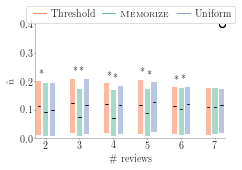

In [29]:
# T=7.0 alpha=0.1
# latexify(fig_width=2,largeFonts=False,columns=2,font_scale=1.0)
latexify(fig_width=3.4, largeFonts=True)

plot_perf_by_reps_boxed(top_k_99_reps, with_threshold=True, std=False, 
                        max_rev=7, median=True, stats=stats)

format_axes(plt.gca())
plt.ylabel("$\hat{n}$")
plt.xlabel("\# reviews")

plt.ylim(0, 0.4)
# plt.savefig(plot_path('empirical_p_recall_duo_new_boxed_split_T_3.pdf'), bbox_inches='tight',pad_inches=0)
# plt.savefig(plot_path('empirical_p_recall_duo_new_boxed.pdf'), bbox_inches='tight',pad_inches=0)
#plt.xlim(0,6*2+)

In [33]:
middle_dur_pairs = filter_by_duration(
    durations_dict=duo_durations, 
    pairs=training_pairs, 
    T=8, alpha=0.4,
    verbose=True)

205750 / 1337453 = 15.38% sequences selected.


In [34]:
%%time
users = list(map(lambda f:f[0], middle_dur_pairs))

from collections import OrderedDict
users_ = {}
for u in users:
    if u in users_:
        users_[u] += 1
    else:
        users_[u] = 0
users_ = OrderedDict(sorted(users_.items(), key=lambda x: -x[1]))

users_ = OrderedDict(filter(lambda x: x[1]>70, users_.items()))
print('Number of users = ', len(users_))

Number of users =  322
CPU times: user 104 ms, sys: 6.59 ms, total: 110 ms
Wall time: 107 ms


In [49]:
%%time

results = []
for ind, u in enumerate(users_):
    if ind % 100 == 0:
        print("Completed = ", ind / len(users_))
    
    middle_dur_pairs_users = filter_by_users(middle_dur_pairs, [u], False)    
    perf = duo_forgetting_rate
    with_exact_reps = True
    with_training = True
    threshold = 1.0
    
    def top_k_reps_worker(reps):
        max_reps = None if not with_exact_reps else reps + 1
        stats_dict = duo_stats_99 if not with_training else duo_stats_training
        # pairs = duo_pairs if not with_training else training_pairs
        pairs = middle_dur_pairs_users
        return reps, calc_top_memorize(stats_dict, perf, pairs=pairs, 
                                     min_reps=reps, max_reps=max_reps, with_overall=True,
                                     only_finite=True, with_threshold=True)

    reps_range = np.arange(1 if not with_training else 2, 10)

    # For performance
    #with MP.Pool(9) as pool:
    #    top_k_99_reps = pool.map(top_k_reps_worker, reps_range)
    #
    # For debugging
    top_k_99_reps = []
    for i in reps_range:
        reps, (corr_mem, corr_uniform, corr_thresh) = top_k_reps_worker(i)
        if corr_mem[1] < threshold:
            results.append((u, reps, corr_mem[0], "Memorize" ))
 

Completed =  0.0


/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3013: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/utkarshu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Completed =  0.3105590062111801
Completed =  0.6211180124223602
Completed =  0.9316770186335404
CPU times: user 10.3 s, sys: 130 ms, total: 10.5 s
Wall time: 10.5 s


/home/utkarshu/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/utkarshu/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


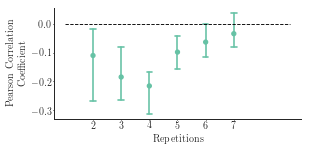

In [50]:
c1, c2, c3 = sns.color_palette("Set2",n_colors=3)
df = pd.DataFrame(results, columns=["user", "Repetitions", 
                                    "Pearson Correlation\nCoefficient", "Policy"])
#df.plot("reps","correlation",kind="bar")
df = df[df['Repetitions']<8]
df = df[df["Policy"]=="Memorize"]
sns.factorplot("Repetitions", "Pearson Correlation\nCoefficient",hue="Policy", data=df, size=2.2,
               aspect=2, legend=False, estimator=np.median, ci=68,capsize=.2,#,hue_order=["Memorize", "Threshold","Uniform"],
               palette=sns.color_palette("Set2",n_colors=3), linestyles=[""])
plt.hlines(0,-1,7, linestyle="--")
#plt.legend(loc=9, ncol=3)
#plt.savefig(plot_path('user_n_perf_all.pdf'), 
#            bbox_inches='tight',pad_inches=0)